In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(30,10)})

import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

from ipyleaflet import Map, basemaps, basemap_to_tiles, Polygon, WKTLayer, Heatmap

from pyproj import Proj, transform

from shapely import wkt

from colour import Color

import geopandas
import rtree


Importing our datasets

In [3]:
df_crime_complaints = pd.read_csv("nypdcomplaintsytd.csv")
df_crime_complaints.drop_duplicates()
df_crime_complaints

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,JURIS_DESC,...,PARKS_NM,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,Lat_Lon,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,244685801,69,BROOKLYN,01/01/2015,00:00:00,NaN,(null),COMPLETED,(null),N.Y. POLICE DEPT,...,(null),157.0,RAPE 1,RESIDENCE-HOUSE,05/04/2022,POINT (-73.9052572032302 40.6486135510607),1010541,175595,40.648614,-73.905257
1,242250195,42,BRONX,03/17/2022,15:23:00,03/17/2022,15:28:00,ATTEMPTED,(null),N.Y. POLICE DEPT,...,(null),375.0,"ROBBERY,PHARMACY",DRUG STORE,03/17/2022,POINT (-73.905435 40.831899),1010419,242374,40.831899,-73.905435
2,242385774,123,STATEN ISLAND,03/20/2022,11:52:00,NaN,(null),COMPLETED,(null),N.Y. POLICE DEPT,...,(null),638.0,"HARASSMENT,SUBD 3,4,5",RESIDENCE-HOUSE,03/20/2022,POINT (-74.209485 40.545405),926029,138052,40.545405,-74.209485
3,242643555,121,STATEN ISLAND,03/24/2022,15:00:00,03/24/2022,22:00:00,COMPLETED,(null),N.Y. POLICE DEPT,...,(null),157.0,RAPE 1,RESIDENCE-HOUSE,03/25/2022,POINT (-74.1492376947323 40.6231883776008),942822,166353,40.623188,-74.149238
4,242816732,42,BRONX,03/29/2022,15:24:00,03/29/2022,15:30:00,COMPLETED,(null),N.Y. POLICE DEPT,...,(null),389.0,"ROBBERY,DWELLING",RESIDENCE-HOUSE,03/29/2022,POINT (-73.906484 40.82567),1010131,240105,40.825670,-73.906484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256792,247399166,33,MANHATTAN,06/30/2022,22:10:00,06/30/2022,22:25:00,COMPLETED,(null),N.Y. POLICE DEPT,...,(null),113.0,"MENACING,UNCLASSIFIED",RESIDENCE - APT. HOUSE,06/30/2022,POINT (-73.937557 40.838991),1001528,244950,40.838991,-73.937557
256793,247392181,113,QUEENS,06/30/2022,19:26:00,06/30/2022,19:40:00,COMPLETED,(null),N.Y. POLICE DEPT,...,(null),707.0,"IMPERSONATION 2, PUBLIC SERVAN",PARKING LOT/GARAGE (PUBLIC),06/30/2022,POINT (-73.79152522 40.6734796),1042079,184712,40.673480,-73.791525
256794,247383348,90,BROOKLYN,06/30/2022,12:36:00,06/30/2022,12:40:00,COMPLETED,(null),N.Y. POLICE DEPT,...,(null),916.0,LEAVING SCENE-ACCIDENT-PERSONA,STREET,06/30/2022,POINT (-73.95123582 40.71169241),997769,198569,40.711692,-73.951236
256795,247434393,109,QUEENS,06/30/2022,14:30:00,06/30/2022,15:00:00,COMPLETED,(null),N.Y. POLICE DEPT,...,(null),638.0,"HARASSMENT,SUBD 3,4,5",COMMERCIAL BUILDING,06/30/2022,POINT (-73.810555 40.788796),1036709,226713,40.788796,-73.810555


Cleaning data by dropping unnecessary columns

Use label encoder to encode the offense description to allow for classification later

Parse dates and split them into hours, days, months, and years

In [3]:
#encode the category of OFNS_DESC
df = df_crime_complaints.copy()

df = df.drop(columns = ['CMPLNT_NUM','BORO_NM','CMPLNT_TO_DT','CMPLNT_TO_TM','CRM_ATPT_CPTD_CD','HADEVELOPT',
'JURIS_DESC','KY_CD','LAW_CAT_CD','LOC_OF_OCCUR_DESC','PARKS_NM','PD_CD','PD_DESC','PREM_TYP_DESC',
'RPT_DT','X_COORD_CD','Y_COORD_CD'])

from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df['OFNS_DESC_ID'] = lb_make.fit_transform(df_crime_complaints['OFNS_DESC'])

#split date into columns
df[["month", "day", "year"]] = df["CMPLNT_FR_DT"].str.split("/", expand = True)
df= df.drop(columns = 'CMPLNT_FR_DT')

#get only the hour in order to do random forest
df['CMPLNT_FR_TM'] = pd.to_datetime(df['CMPLNT_FR_TM'])
# extract hour from the timestamp column to create an time_hour column
df['hour'] = df['CMPLNT_FR_TM'].dt.hour
df= df.drop(columns = 'CMPLNT_FR_TM')

df

#df.head() #Results in appending a new column to df

,ADDR_PCT_CD,OFNS_DESC,Lat_Lon,Latitude,Longitude,OFNS_DESC_ID,month,day,year,hour
0,69,RAPE,POINT (-73.9052572032302 40.6486135510607),40.648614,-73.905257,52,01,01,2015,0
1,42,ROBBERY,POINT (-73.905435 40.831899),40.831899,-73.905435,53,03,17,2022,15
2,123,HARRASSMENT 2,POINT (-74.209485 40.545405),40.545405,-74.209485,26,03,20,2022,11
3,121,RAPE,POINT (-74.1492376947323 40.6231883776008),40.623188,-74.149238,52,03,24,2022,15
4,42,ROBBERY,POINT (-73.906484 40.82567),40.825670,-73.906484,53,03,29,2022,15
...,...,...,...,...,...,...,...,...,...,...
256792,33,ASSAULT 3 & RELATED OFFENSES,POINT (-73.937557 40.838991),40.838991,-73.937557,6,06,30,2022,22
256793,113,FRAUDS,POINT (-73.79152522 40.6734796),40.673480,-73.791525,21,06,30,2022,19
256794,90,VEHICLE AND TRAFFIC LAWS,POINT (-73.95123582 40.71169241),40.711692,-73.951236,59,06,30,2022,12
256795,109,HARRASSMENT 2,POINT (-73.810555 40.788796),40.788796,-73.810555,26,06,30,2022,14


Create legend of label encodings for own reference

In [4]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

duff = df_crime_complaints.copy()

my_encodings = {l: i for (i, l) in enumerate(lb_make.fit(duff["OFNS_DESC"]).classes_)}


In [6]:
my_encodings["PETIT LARCENY"]

48

Import sidewalk cafe data; standardize the co-ordinate reference system as 2263 to ensure proper calculation of distances

In [17]:
import geopandas as gpd

sidewalk = pd.read_csv('./sidewalk_cafe.csv')
sidewalk = sidewalk[['LATITUDE','LONGITUDE']]



sidewalk = gpd.GeoDataFrame(sidewalk, geometry=gpd.points_from_xy(sidewalk['LONGITUDE'], sidewalk['LATITUDE']) )
sidewalk.drop(columns = ['LATITUDE','LONGITUDE'])
sidewalk = sidewalk.set_crs(crs=4326).to_crs(2263)
sidewalk

,LATITUDE,LONGITUDE,geometry
0,40.741714,-73.992162,POINT (986422.000 209503.014)
1,40.772109,-73.955701,POINT (996520.000 220580.014)
2,40.709658,-74.009375,POINT (981651.000 197824.014)
3,40.687004,-73.984257,POINT (988616.000 189571.014)
4,40.673729,-73.991723,POINT (986546.000 184734.014)
...,...,...,...
1111,40.776489,-73.911132,POINT (1008863.000 222185.014)
1112,40.786657,-73.975542,POINT (991023.000 225878.014)
1113,40.756956,-73.967215,POINT (993333.000 215058.014)
1114,40.739652,-74.005940,POINT (982604.000 208752.014)


Import plaza data; standardize the co-ordinate reference system as 2263 to ensure proper calculation of distances; find centroid and convert shape of plaza to use for distance calculations

In [18]:
#making plaza data set into a point, finding centroid

plazas = geopandas.read_file("./Public Plazas/geo_export_0cada674-fe76-4376-9b5d-3263e6c47773.shp")
plazas = plazas[['geometry']]
plazas
from shapely.geometry import Polygon

plazas

plazas['geometry'] = plazas['geometry'].to_crs(2263)
plazas['geometry'] = plazas['geometry'].centroid
# plazas['geometry'] = plazas['geometry'].to_crs(4326)
plazas


,geometry
0,POINT (987963.128 194013.674)
1,POINT (987101.795 191141.854)
2,POINT (985497.905 194051.456)
3,POINT (986583.588 193099.097)
4,POINT (986717.410 194376.305)
...,...
1355,POINT (1007604.989 185309.585)
1356,POINT (1006987.824 183920.199)
1357,POINT (1022223.401 186814.603)
1358,POINT (1012159.254 176736.520)


Convert dataframe to a geodataframe using the Longitude and Latitude columns as geometry; standardise coordinate reference system as 2263 to allow for accurate distance calculations

In [21]:
#check if thing is even right
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

gdf = gdf.set_crs(crs=4326).to_crs(crs=2263)
gdf

,ADDR_PCT_CD,OFNS_DESC,Lat_Lon,Latitude,Longitude,OFNS_DESC_ID,month,day,year,hour,geometry
0,69,RAPE,POINT (-73.9052572032302 40.6486135510607),40.648614,-73.905257,52,01,01,2015,0,POINT (1010540.605 175598.004)
1,42,ROBBERY,POINT (-73.905435 40.831899),40.831899,-73.905435,53,03,17,2022,15,POINT (1010419.179 242374.642)
2,123,HARRASSMENT 2,POINT (-74.209485 40.545405),40.545405,-74.209485,26,03,20,2022,11,POINT (926029.187 138051.890)
3,121,RAPE,POINT (-74.1492376947323 40.6231883776008),40.623188,-74.149238,52,03,24,2022,15,POINT (942821.592 166356.001)
4,42,ROBBERY,POINT (-73.906484 40.82567),40.825670,-73.906484,53,03,29,2022,15,POINT (1010131.310 240104.878)
...,...,...,...,...,...,...,...,...,...,...,...
256792,33,ASSAULT 3 & RELATED OFFENSES,POINT (-73.937557 40.838991),40.838991,-73.937557,6,06,30,2022,22,POINT (1001528.148 244950.553)
256793,113,FRAUDS,POINT (-73.79152522 40.6734796),40.673480,-73.791525,21,06,30,2022,19,POINT (1042079.000 184711.999)
256794,90,VEHICLE AND TRAFFIC LAWS,POINT (-73.95123582 40.71169241),40.711692,-73.951236,59,06,30,2022,12,POINT (997769.000 198568.998)
256795,109,HARRASSMENT 2,POINT (-73.810555 40.788796),40.788796,-73.810555,26,06,30,2022,14,POINT (1036709.460 226713.286)


Calculate distance from nearest cafe for each crime, and add it as a column

In [22]:
t = gdf.geometry.apply(lambda x: sidewalk.distance(x).min())
df['nearest_cafe'] = t
df

,ADDR_PCT_CD,OFNS_DESC,Lat_Lon,Latitude,Longitude,OFNS_DESC_ID,month,day,year,hour,geometry,nearest_cafe
0,69,RAPE,POINT (-73.9052572032302 40.6486135510607),40.648614,-73.905257,52,01,01,2015,0,POINT (-73.90526 40.64861),4600.181089
1,42,ROBBERY,POINT (-73.905435 40.831899),40.831899,-73.905435,53,03,17,2022,15,POINT (-73.90543 40.83190),9106.247052
2,123,HARRASSMENT 2,POINT (-74.209485 40.545405),40.545405,-74.209485,26,03,20,2022,11,POINT (-74.20949 40.54541),55977.751561
3,121,RAPE,POINT (-74.1492376947323 40.6231883776008),40.623188,-74.149238,52,03,24,2022,15,POINT (-74.14924 40.62319),32338.780363
4,42,ROBBERY,POINT (-73.906484 40.82567),40.825670,-73.906484,53,03,29,2022,15,POINT (-73.90648 40.82567),9861.906766
...,...,...,...,...,...,...,...,...,...,...,...,...
256792,33,ASSAULT 3 & RELATED OFFENSES,POINT (-73.937557 40.838991),40.838991,-73.937557,6,06,30,2022,22,POINT (-73.93756 40.83899),840.032631
256793,113,FRAUDS,POINT (-73.79152522 40.6734796),40.673480,-73.791525,21,06,30,2022,19,POINT (-73.79153 40.67348),20334.263153
256794,90,VEHICLE AND TRAFFIC LAWS,POINT (-73.95123582 40.71169241),40.711692,-73.951236,59,06,30,2022,12,POINT (-73.95124 40.71169),200.143324
256795,109,HARRASSMENT 2,POINT (-73.810555 40.788796),40.788796,-73.810555,26,06,30,2022,14,POINT (-73.81055 40.78880),8789.144417


Examining crime that happened neares tto sidewalk cafe

In [23]:
df.loc[df["nearest_cafe"]==df["nearest_cafe"].min()]

,ADDR_PCT_CD,OFNS_DESC,Lat_Lon,Latitude,Longitude,OFNS_DESC_ID,month,day,year,hour,geometry,nearest_cafe
235481,6,BURGLARY,POINT (-74.005443 40.739083),40.739083,-74.005443,8,06,20,2022,17,POINT (-74.00544 40.73908),2.690704


Examining precinct 19 data

In [24]:
df.loc[df["ADDR_PCT_CD"] == 19]

,ADDR_PCT_CD,OFNS_DESC,Lat_Lon,Latitude,Longitude,OFNS_DESC_ID,month,day,year,hour,geometry,nearest_cafe
30,19,ROBBERY,POINT (-73.96380658 40.76717714),40.767177,-73.963807,53,01,01,2022,2,POINT (-73.96381 40.76718),739.653829
142,19,ASSAULT 3 & RELATED OFFENSES,POINT (-73.95371913 40.78205508),40.782055,-73.953719,6,01,10,2011,17,POINT (-73.95372 40.78206),72.808830
241,19,ASSAULT 3 & RELATED OFFENSES,POINT (-73.954784 40.779159),40.779159,-73.954784,6,12,31,2021,20,POINT (-73.95478 40.77916),287.948766
246,19,GRAND LARCENY OF MOTOR VEHICLE,POINT (-73.955296 40.770888),40.770888,-73.955296,25,12,16,2021,20,POINT (-73.95530 40.77089),318.445614
332,19,GRAND LARCENY,POINT (-73.960445 40.771401),40.771401,-73.960445,24,08,15,2020,14,POINT (-73.96045 40.77140),303.453820
...,...,...,...,...,...,...,...,...,...,...,...,...
256558,19,PETIT LARCENY,POINT (-73.947334 40.783906),40.783906,-73.947334,48,06,30,2022,10,POINT (-73.94733 40.78391),469.353624
256593,19,PETIT LARCENY,POINT (-73.947334 40.783906),40.783906,-73.947334,48,06,30,2022,16,POINT (-73.94733 40.78391),469.353624
256625,19,PETIT LARCENY,POINT (-73.948248 40.776403),40.776403,-73.948248,48,06,30,2022,9,POINT (-73.94825 40.77640),791.098737
256652,19,ASSAULT 3 & RELATED OFFENSES,POINT (-73.95558406 40.77949772),40.779498,-73.955584,6,06,30,2022,20,POINT (-73.95558 40.77950),199.161537


Calculate distance from nearest plaza for each crime, and add it as a column

In [25]:

nearest_plaza = gdf.geometry.apply(lambda x: plazas.distance(x).min())
df['nearest_plaza'] = nearest_plaza
df

,ADDR_PCT_CD,OFNS_DESC,Lat_Lon,Latitude,Longitude,OFNS_DESC_ID,month,day,year,hour,geometry,nearest_cafe,nearest_plaza
0,69,RAPE,POINT (-73.9052572032302 40.6486135510607),40.648614,-73.905257,52,01,01,2015,0,POINT (-73.90526 40.64861),4600.181089,1978.950142
1,42,ROBBERY,POINT (-73.905435 40.831899),40.831899,-73.905435,53,03,17,2022,15,POINT (-73.90543 40.83190),9106.247052,324.757042
2,123,HARRASSMENT 2,POINT (-74.209485 40.545405),40.545405,-74.209485,26,03,20,2022,11,POINT (-74.20949 40.54541),55977.751561,7452.239089
3,121,RAPE,POINT (-74.1492376947323 40.6231883776008),40.623188,-74.149238,52,03,24,2022,15,POINT (-74.14924 40.62319),32338.780363,3194.973830
4,42,ROBBERY,POINT (-73.906484 40.82567),40.825670,-73.906484,53,03,29,2022,15,POINT (-73.90648 40.82567),9861.906766,1137.214582
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256792,33,ASSAULT 3 & RELATED OFFENSES,POINT (-73.937557 40.838991),40.838991,-73.937557,6,06,30,2022,22,POINT (-73.93756 40.83899),840.032631,244.772460
256793,113,FRAUDS,POINT (-73.79152522 40.6734796),40.673480,-73.791525,21,06,30,2022,19,POINT (-73.79153 40.67348),20334.263153,2589.534035
256794,90,VEHICLE AND TRAFFIC LAWS,POINT (-73.95123582 40.71169241),40.711692,-73.951236,59,06,30,2022,12,POINT (-73.95124 40.71169),200.143324,2235.858844
256795,109,HARRASSMENT 2,POINT (-73.810555 40.788796),40.788796,-73.810555,26,06,30,2022,14,POINT (-73.81055 40.78880),8789.144417,3429.301293


Import shapefile of street centrelines using geopandas

In [26]:
street = geopandas.read_file("./NYC Street Centerline (CSCL)/geo_export_95815ce5-2d43-4699-ad96-6facca18ed40.shp")
street

,bike_lane,bike_trafd,borocode,date_creat,time_creat,frm_lvl_co,full_stree,l_blkfc_id,l_high_hn,l_low_hn,...,rw_type,shape_leng,snow_pri,st_label,st_name,st_width,status,to_lvl_co,trafdir,geometry
0,None,None,1,2007-11-29,00:00:00.000,13.0,BATTERY PL,2.122626e+08,64,50,...,1.0,262.777812,C,BATTERY PL,BATTERY,42.0,2,13.0,TW,"LINESTRING (-74.01793 40.70617, -74.01787 40.7..."
1,None,None,1,2007-11-29,00:00:00.000,13.0,BATTERY PL,1.222601e+09,82,66,...,1.0,259.415989,C,BATTERY PL,BATTERY,42.0,2,13.0,TW,"LINESTRING (-74.01757 40.70684, -74.01712 40.7..."
2,None,None,1,2007-11-29,00:00:00.000,13.0,BATTERY PL,1.222601e+09,98,84,...,1.0,280.444781,C,BATTERY PL,BATTERY,42.0,2,13.0,TW,"LINESTRING (-74.01712 40.70746, -74.01663 40.7..."
3,None,None,1,2007-11-29,00:00:00.000,13.0,BATTERY PL,2.122626e+08,None,None,...,1.0,32.070139,C,BATTERY PL,BATTERY,42.0,2,13.0,TW,"LINESTRING (-74.01694 40.70481, -74.01705 40.7..."
4,None,None,1,2011-04-22,00:00:00.000,13.0,BATTERY PL,2.122626e+08,None,None,...,1.0,206.271850,C,BATTERY PL,BATTERY,24.0,2,13.0,TF,"LINESTRING (-74.01429 40.70455, -74.01437 40.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120879,None,None,4,2018-10-03,00:00:00.000,13.0,UNION TPKE,0.000000e+00,None,None,...,3.0,27.854928,H,UNION TPKE,UNION,0.0,2,13.0,TF,"LINESTRING (-73.83376 40.71312, -73.83371 40.7..."
120880,None,None,4,2018-10-03,00:00:00.000,13.0,UNION TPKE,0.000000e+00,None,None,...,3.0,26.532025,H,UNION TPKE,UNION,0.0,2,13.0,TF,"LINESTRING (-73.83379 40.71305, -73.83378 40.7..."
120881,None,None,4,2007-11-29,00:00:00.000,13.0,LAUREL HILL BLVD,1.022660e+08,None,None,...,1.0,875.437581,C,LAUREL HILL BLVD,LAUREL HILL,22.0,2,13.0,FT,"LINESTRING (-73.92408 40.73466, -73.92412 40.7..."
120882,None,None,3,2007-11-29,00:00:00.000,13.0,TILDEN AVE,1.922607e+09,2299,2131,...,1.0,682.433055,S,TILDEN AVE,TILDEN,36.0,2,13.0,TW,"LINESTRING (-73.95811 40.64652, -73.95685 40.6..."


Extract only the relevant parts of the data set, i.e. street name and its geometry

In [27]:
street = street[["full_stree", "geometry"]]

In [28]:
street

,full_stree,geometry
0,BATTERY PL,"LINESTRING (-74.01793 40.70617, -74.01787 40.7..."
1,BATTERY PL,"LINESTRING (-74.01757 40.70684, -74.01712 40.7..."
2,BATTERY PL,"LINESTRING (-74.01712 40.70746, -74.01663 40.7..."
3,BATTERY PL,"LINESTRING (-74.01694 40.70481, -74.01705 40.7..."
4,BATTERY PL,"LINESTRING (-74.01429 40.70455, -74.01437 40.7..."
...,...,...
120879,UNION TPKE,"LINESTRING (-73.83376 40.71312, -73.83371 40.7..."
120880,UNION TPKE,"LINESTRING (-73.83379 40.71305, -73.83378 40.7..."
120881,LAUREL HILL BLVD,"LINESTRING (-73.92408 40.73466, -73.92412 40.7..."
120882,TILDEN AVE,"LINESTRING (-73.95811 40.64652, -73.95685 40.6..."


Import the nypd precinct data

In [29]:
nypd_precincts=pd.read_csv("nypp.csv")
nypd_precincts

,the_geom,Precinct,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-74.04387761573918 40.69018767...,1,80282.636260,4.728646e+07
1,MULTIPOLYGON (((-73.98863862848766 40.72293372...,5,18807.124911,1.809453e+07
2,MULTIPOLYGON (((-73.99968423039347 40.73855247...,6,26413.239024,2.210333e+07
3,MULTIPOLYGON (((-73.97345568776892 40.71896313...,7,17287.544493,1.836667e+07
4,MULTIPOLYGON (((-73.97160900246391 40.72672340...,9,19772.510741,2.139539e+07
...,...,...,...,...
72,MULTIPOLYGON (((-73.85892056444803 40.76240640...,115,60059.410758,1.141197e+08
73,MULTIPOLYGON (((-74.0535675357038 40.603696467...,120,92952.358864,2.323380e+08
74,MULTIPOLYGON (((-74.15945602438066 40.64144833...,121,136811.464647,4.755776e+08
75,MULTIPOLYGON (((-74.05050806403247 40.56642203...,122,154842.244366,4.548530e+08


Convert nypd precinct data in to geodataframe by parsing WKT object strings 

In [30]:
nypd_precincts['the_geom'] = geopandas.GeoSeries.from_wkt(nypd_precincts['the_geom'])
precincts = geopandas.GeoDataFrame(nypd_precincts, geometry='the_geom')

Use spatial join to join the precinct and the street centrelines. Important for optimisation later.

In [31]:
import pygeos
geopandas.options.use_pygeos = True

#spatial join: https://geopandas.org/en/stable/gallery/spatial_joins.html
street_join = street.sjoin(precincts, how="left", predicate="within")
street_join

/opt/homebrew/lib/python3.10/site-packages/geopandas/geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


,full_stree,geometry,index_right,Precinct,Shape_Leng,Shape_Area
0,BATTERY PL,"LINESTRING (-74.01793 40.70617, -74.01787 40.7...",0.0,1.0,80282.636260,4.728646e+07
1,BATTERY PL,"LINESTRING (-74.01757 40.70684, -74.01712 40.7...",0.0,1.0,80282.636260,4.728646e+07
2,BATTERY PL,"LINESTRING (-74.01712 40.70746, -74.01663 40.7...",0.0,1.0,80282.636260,4.728646e+07
3,BATTERY PL,"LINESTRING (-74.01694 40.70481, -74.01705 40.7...",0.0,1.0,80282.636260,4.728646e+07
4,BATTERY PL,"LINESTRING (-74.01429 40.70455, -74.01437 40.7...",0.0,1.0,80282.636260,4.728646e+07
...,...,...,...,...,...,...
120879,UNION TPKE,"LINESTRING (-73.83376 40.71312, -73.83371 40.7...",69.0,112.0,42560.718042,8.921146e+07
120880,UNION TPKE,"LINESTRING (-73.83379 40.71305, -73.83378 40.7...",69.0,112.0,42560.718042,8.921146e+07
120881,LAUREL HILL BLVD,"LINESTRING (-73.92408 40.73466, -73.92412 40.7...",65.0,108.0,73737.924984,1.394698e+08
120882,TILDEN AVE,"LINESTRING (-73.95811 40.64652, -73.95685 40.6...",46.0,70.0,49075.568430,8.217188e+07


Use label encoder to encode street names, so that we can use them in the classifier model later on. Create a dictionary for personal reference.

In [32]:
lb_make_street = LabelEncoder()
street_join['full_stree_id'] = lb_make_street.fit_transform(street_join['full_stree'])

In [33]:
street_join_dict = street_join[["full_stree","full_stree_id"]]

In [34]:
street_join_dict=street_join_dict.drop_duplicates()

In [35]:
street_join_dict

,full_stree,full_stree_id
0,BATTERY PL,1380
5,W THAMES ST,10002
8,1 PL,5
10,HUGH L CAREY TUNL,5567
18,BROAD ST,2182
...,...,...
120729,SANTINA DR,8527
120766,LATHAM PL,6167
120776,HINTON ST,5446
120781,BOYLAN ST,2032


Define a custom function that:
- for each crime,
- checks against each street in the precinct for closest street to the crime
- tags the crime as occurring on the street identified

In [36]:
def nearest(point,street):
    precinct = point["ADDR_PCT_CD"]
    streets_to_check = street.loc[street["Precinct"]==precinct]
    distances = streets_to_check.distance(point["geometry"]).idxmin()
    dist = street.iloc[distances,:]["full_stree_id"]
    return dist

Backup dataframes to prevent data loss while applying nearest function, due to size of the dataset

In [37]:
df.to_csv('df.csv')

In [38]:
gdf.to_csv('gdf.csv')

Apply the nearest function to get the nearest street for all crimes.

In [39]:
street_join= street_join.to_crs(2263)
gdf=gdf.to_crs(2263)
nearest_street = gdf.apply(lambda x: nearest(x,street_join),  axis =1)

In [40]:
df["nearest_street"] = nearest_street

In [41]:
df

,ADDR_PCT_CD,OFNS_DESC,Lat_Lon,Latitude,Longitude,OFNS_DESC_ID,month,day,year,hour,geometry,nearest_cafe,nearest_plaza,nearest_street
0,69,RAPE,POINT (-73.9052572032302 40.6486135510607),40.648614,-73.905257,52,01,01,2015,0,POINT (-73.90526 40.64861),4600.181089,1978.950142,4547
1,42,ROBBERY,POINT (-73.905435 40.831899),40.831899,-73.905435,53,03,17,2022,15,POINT (-73.90543 40.83190),9106.247052,324.757042,503
2,123,HARRASSMENT 2,POINT (-74.209485 40.545405),40.545405,-74.209485,26,03,20,2022,11,POINT (-74.20949 40.54541),55977.751561,7452.239089,8377
3,121,RAPE,POINT (-74.1492376947323 40.6231883776008),40.623188,-74.149238,52,03,24,2022,15,POINT (-74.14924 40.62319),32338.780363,3194.973830,8208
4,42,ROBBERY,POINT (-73.906484 40.82567),40.825670,-73.906484,53,03,29,2022,15,POINT (-73.90648 40.82567),9861.906766,1137.214582,3793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256792,33,ASSAULT 3 & RELATED OFFENSES,POINT (-73.937557 40.838991),40.838991,-73.937557,6,06,30,2022,22,POINT (-73.93756 40.83899),840.032631,244.772460,1043
256793,113,FRAUDS,POINT (-73.79152522 40.6734796),40.673480,-73.791525,21,06,30,2022,19,POINT (-73.79153 40.67348),20334.263153,2589.534035,8305
256794,90,VEHICLE AND TRAFFIC LAWS,POINT (-73.95123582 40.71169241),40.711692,-73.951236,59,06,30,2022,12,POINT (-73.95124 40.71169),200.143324,2235.858844,5509
256795,109,HARRASSMENT 2,POINT (-73.810555 40.788796),40.788796,-73.810555,26,06,30,2022,14,POINT (-73.81055 40.78880),8789.144417,3429.301293,164


Find out which street has the most crime through observing the value counts

In [43]:
df["nearest_street"].value_counts()

2183     5899
503      3038
9160     1937
10161    1737
7370     1674
         ... 
8051        1
1513        1
2762        1
6788        1
1560        1
Name: nearest_street, Length: 5747, dtype: int64

Check the street name against the dictionary, identify Broadway as the street where most crimes happen nearby

In [42]:
street_join_dict[street_join_dict["full_stree_id"]==2183]

,full_stree,full_stree_id
377,BROADWAY,2183


Second backup of dataframe with optional restoration codeblock

In [44]:
df.to_csv("df.csv")

In [6]:
## uncomment to restore from csv

# df=pd.read_csv("df.csv")
# df.drop(columns=["Unnamed: 0"],inplace=True)
# df

,ADDR_PCT_CD,OFNS_DESC,Lat_Lon,Latitude,Longitude,OFNS_DESC_ID,month,day,year,hour,geometry,nearest_cafe,nearest_plaza,nearest_street
0,69,RAPE,POINT (-73.9052572032302 40.6486135510607),40.648614,-73.905257,52,1,1,2015,0,POINT (-73.9052572032302 40.6486135510607),4600.181089,1978.950142,4547
1,42,ROBBERY,POINT (-73.905435 40.831899),40.831899,-73.905435,53,3,17,2022,15,POINT (-73.905435 40.831899),9106.247052,324.757042,503
2,123,HARRASSMENT 2,POINT (-74.209485 40.545405),40.545405,-74.209485,26,3,20,2022,11,POINT (-74.209485 40.545405),55977.751561,7452.239089,8377
3,121,RAPE,POINT (-74.1492376947323 40.6231883776008),40.623188,-74.149238,52,3,24,2022,15,POINT (-74.1492376947323 40.6231883776008),32338.780363,3194.973830,8208
4,42,ROBBERY,POINT (-73.906484 40.82567),40.825670,-73.906484,53,3,29,2022,15,POINT (-73.906484 40.82567),9861.906766,1137.214582,3793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256792,33,ASSAULT 3 & RELATED OFFENSES,POINT (-73.937557 40.838991),40.838991,-73.937557,6,6,30,2022,22,POINT (-73.937557 40.838991),840.032631,244.772460,1043
256793,113,FRAUDS,POINT (-73.79152522 40.6734796),40.673480,-73.791525,21,6,30,2022,19,POINT (-73.79152522 40.6734796),20334.263153,2589.534035,8305
256794,90,VEHICLE AND TRAFFIC LAWS,POINT (-73.95123582 40.71169241),40.711692,-73.951236,59,6,30,2022,12,POINT (-73.95123582 40.71169241),200.143324,2235.858844,5509
256795,109,HARRASSMENT 2,POINT (-73.810555 40.788796),40.788796,-73.810555,26,6,30,2022,14,POINT (-73.810555 40.788796),8789.144417,3429.301293,164


Prepare the dataset for training and testing, and construct the classifier model

In [46]:
y = df["OFNS_DESC_ID"]
X = df.drop(['OFNS_DESC','OFNS_DESC_ID','Lat_Lon','geometry'], axis=1)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 44)
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=500, max_features="auto", random_state=44)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
predictions



/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


array([26, 48, 24, ..., 18, 48, 26])

Scoring the model accuracy

In [47]:
rf_model.score(X_test,y_test)

0.30623052959501557

Checking the importance of each feature in the model

In [48]:
importance = rf_model.feature_importances_
columns = X.columns
i = 0

while i <len(columns):
    print (f" Importance of the feature' '{columns[i]}' is {round(importance[i]*100,2)}%.")
    i += 1

 Importance of the feature' 'ADDR_PCT_CD' is 3.28%.
 Importance of the feature' 'Latitude' is 10.08%.
 Importance of the feature' 'Longitude' is 10.03%.
 Importance of the feature' 'month' is 11.63%.
 Importance of the feature' 'day' is 20.39%.
 Importance of the feature' 'year' is 0.5%.
 Importance of the feature' 'hour' is 15.02%.
 Importance of the feature' 'nearest_cafe' is 10.35%.
 Importance of the feature' 'nearest_plaza' is 10.22%.
 Importance of the feature' 'nearest_street' is 8.48%.


Attempting a second model excluding day as a feature, since the day on which a crime is committed is unlikely to be predictive.

In [7]:
y2 = df["OFNS_DESC_ID"]
X2 = df.drop(['OFNS_DESC','OFNS_DESC_ID','Lat_Lon','geometry', 'day','Latitude','Longitude'], axis=1)


from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state = 44)
from sklearn.ensemble import RandomForestClassifier
rf_model2 = RandomForestClassifier(n_estimators=500, max_features="auto")
rf_model2.fit(X_train2, y_train2)

predictions = rf_model2.predict(X_test2)
predictions

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


array([24, 48, 26, ..., 18, 48, 26])

Scoring the second model without day considered as a feature

In [5]:
rf_model2.score(X_test2,y_test2)

0.2944314641744548

Checking the importance of each feature in the model

In [6]:
importance = rf_model2.feature_importances_
columns = X2.columns
i = 0

while i <len(columns):
    print (f" Importance of the feature' '{columns[i]}' is {round(importance[i]*100,2)}%.")
    i += 1

 Importance of the feature' 'ADDR_PCT_CD' is 9.81%.
 Importance of the feature' 'month' is 14.49%.
 Importance of the feature' 'year' is 0.57%.
 Importance of the feature' 'hour' is 19.51%.
 Importance of the feature' 'nearest_cafe' is 19.7%.
 Importance of the feature' 'nearest_plaza' is 19.38%.
 Importance of the feature' 'nearest_street' is 16.53%.


Adding predictions into the actual value dataframe for comparison

In [7]:
prediction_dataframe = X_test2
prediction_dataframe["predicted"] = predictions

In [13]:
prediction_dataframe["predicted_desc"]=lb_make.inverse_transform(prediction_dataframe["predicted"])

In [14]:
prediction_dataframe

,ADDR_PCT_CD,month,year,hour,nearest_cafe,nearest_plaza,nearest_street,predicted,predicted_desc
233429,6,6,2022,16,1134.378143,1571.682444,7805,24,GRAND LARCENY
144409,68,4,2022,17,448.251474,2592.290146,503,48,PETIT LARCENY
181725,73,5,2022,11,5415.080630,771.570797,2178,26,HARRASSMENT 2
205508,70,5,2022,18,6240.382974,1136.011469,4455,48,PETIT LARCENY
147767,79,4,2022,17,1688.582881,950.711298,9339,12,DANGEROUS DRUGS
...,...,...,...,...,...,...,...,...,...
11887,18,1,2022,18,402.641379,228.583646,1237,48,PETIT LARCENY
217542,81,6,2022,17,2263.197017,1328.218599,10327,24,GRAND LARCENY
241378,81,6,2022,13,1103.946021,1735.136604,8072,18,FELONY ASSAULT
80455,13,2,2022,12,276.170416,550.596938,9852,48,PETIT LARCENY


In [15]:
predicted_crime_ratios = prediction_dataframe["predicted_desc"].value_counts().rename_axis('unique_values').reset_index(name='counts')


Use value-counts to identify the type of crime predicted by the model

In [16]:
prediction_dataframe["predicted"].value_counts()

48    20545
26    18261
6      8572
24     6338
10     5882
18     5324
39     1478
8      1342
35     1331
53     1295
54      989
25      876
12      844
20      693
59      627
40      553
13      516
43      260
29      202
56      160
52      134
11      134
50      108
21       78
42       73
57       71
5        54
45       50
36       47
37       43
1        31
7        22
47       20
55       17
41       17
23       11
2         9
33        5
51        4
22        4
49        4
16        4
9         3
31        3
46        2
3         1
15        1
27        1
38        1
Name: predicted, dtype: int64

Construct a bar plot to visualise the predicted crime types by the model.

<AxesSubplot: xlabel='unique_values'>

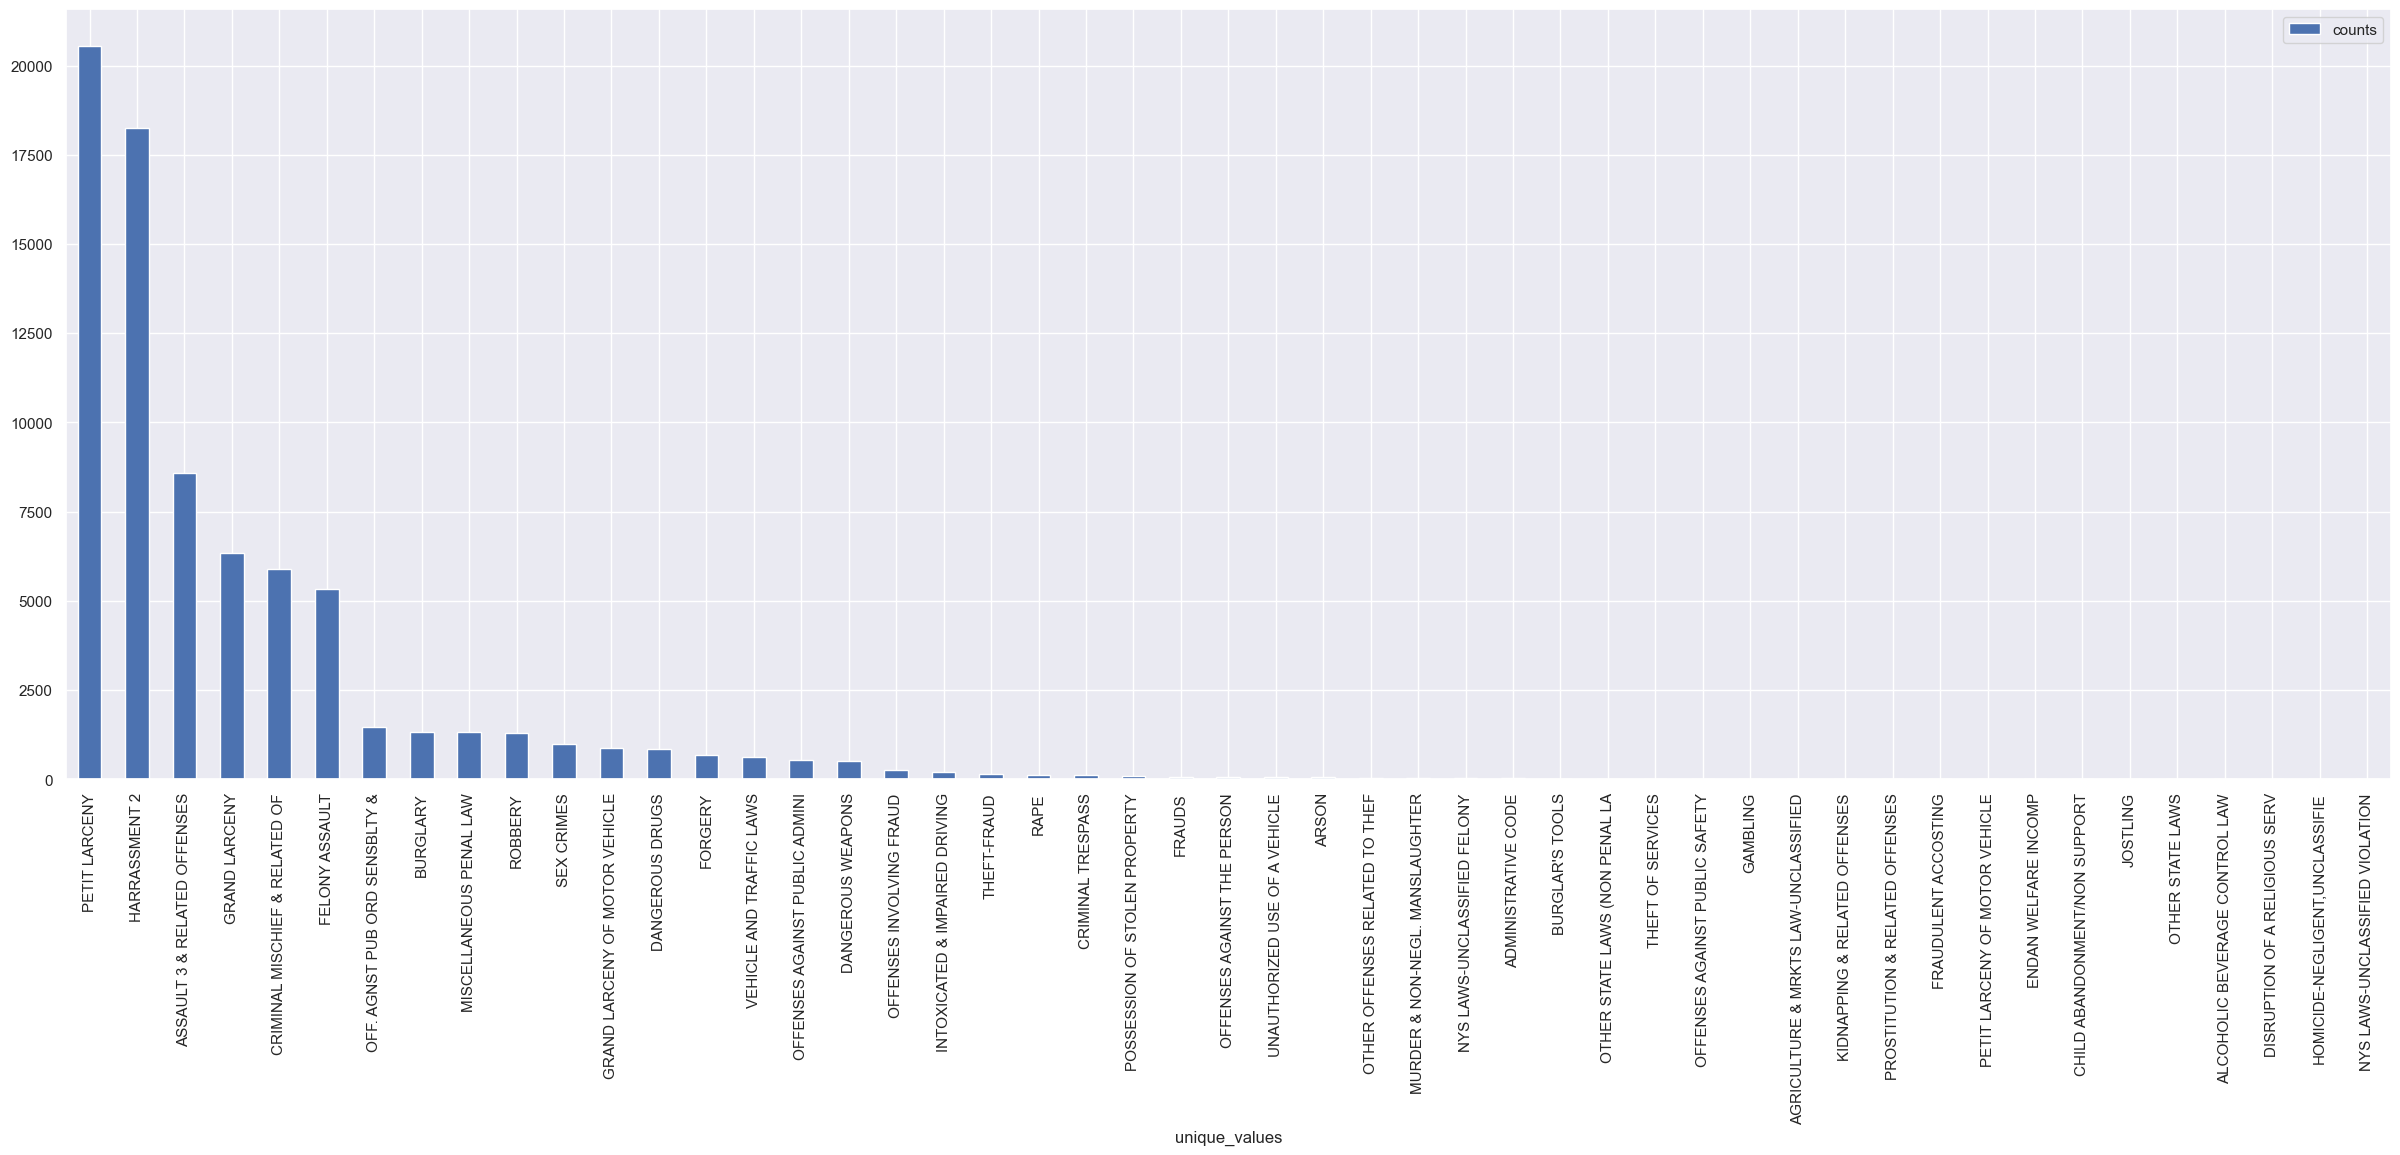

In [17]:
predicted_crime_ratios.plot.bar(x="unique_values", y="counts")

Confusion matrix to investigate the strengths and weaknesses of the model.

<AxesSubplot: >

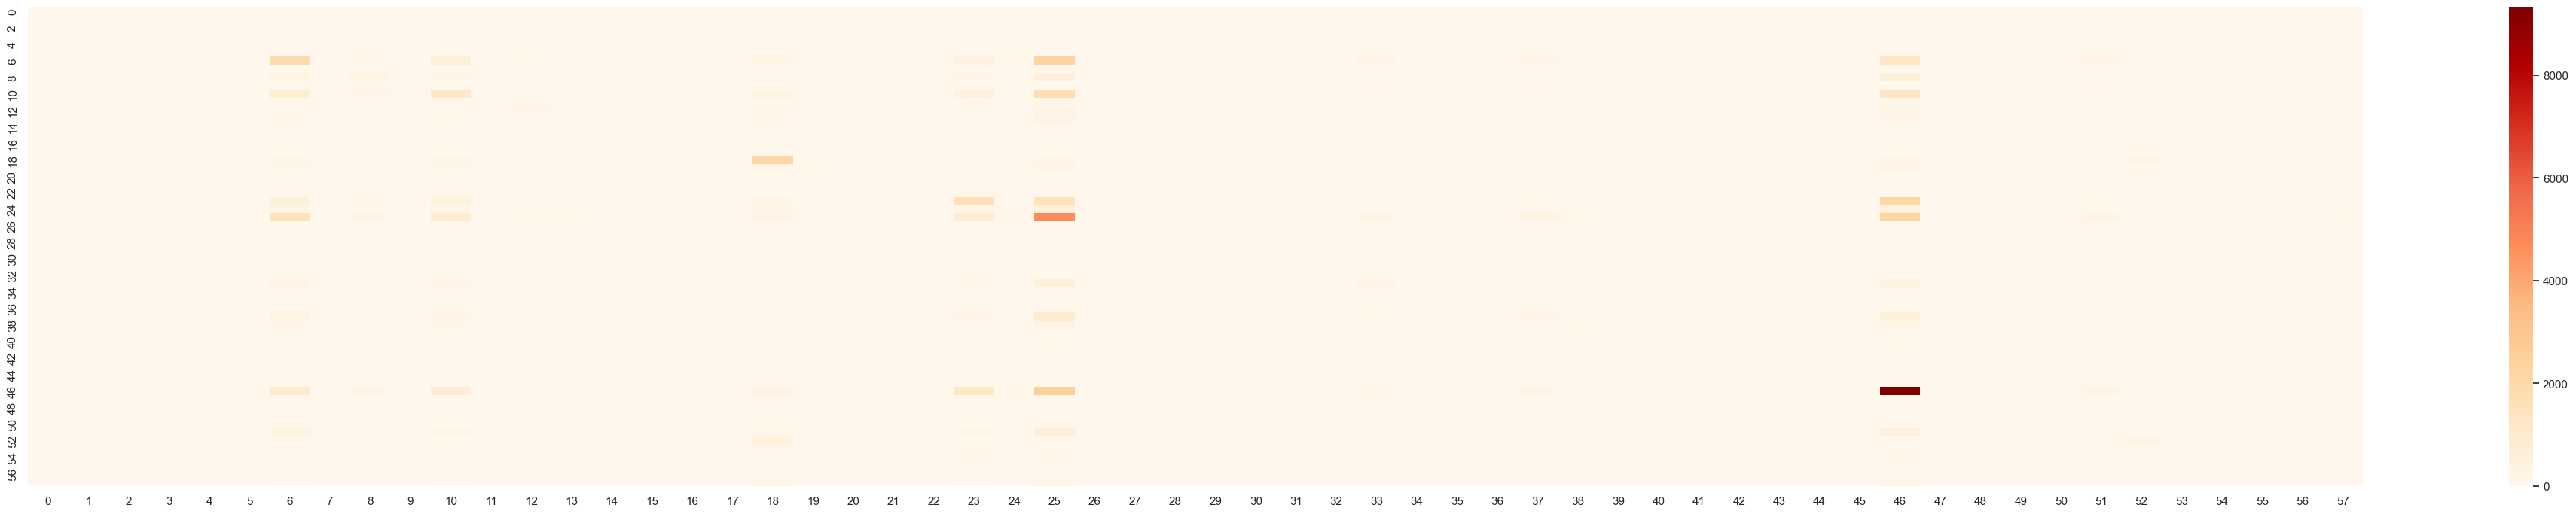

In [18]:
from sklearn.metrics import confusion_matrix

sns.set(rc={'figure.figsize':(50,8.27)})

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test2, predictions)
sns.heatmap(cf_matrix,cmap = "OrRd")

Demonstrating the 2/3 accuracy rate in predicting petit larceny by the model

In [8]:
yt2 = lb_make.inverse_transform(y_test2)
p2 = lb_make.inverse_transform(predictions)
comp = pd.DataFrame()
comp["yt2"]=yt2
comp['pd']=p2
comp['bool']=comp["yt2"]==comp["pd"]
comp[comp["yt2"]=="PETIT LARCENY"]["bool"].value_counts()

True     9339
False    7166
Name: bool, dtype: int64

Attempts at three other models, which consider only Manhattan Island, or the Bronx, or Brooklyn in isolation.

In [24]:
df_manhattan = df
# df_manhattan["ADDR_PCT_CD"] = df["ADDR_PCT_CD"].astype('int')

df_manhattan = df_manhattan[df_manhattan["ADDR_PCT_CD"]<=34]
df_manhattan

,ADDR_PCT_CD,OFNS_DESC,Lat_Lon,Latitude,Longitude,OFNS_DESC_ID,month,day,year,hour,geometry,nearest_cafe,nearest_plaza,nearest_street
6,25,HARRASSMENT 2,POINT (-73.932838 40.799522),40.799522,-73.932838,26,12,31,2021,21,POINT (-73.932838 40.799522),4273.339200,1241.810704,0
12,14,CRIMINAL MISCHIEF & RELATED OF,POINT (-73.98817669 40.74828972),40.748290,-73.988177,10,12,8,2021,23,POINT (-73.98817669 40.74828972),667.849441,137.901026,2183
13,26,PETIT LARCENY,POINT (-73.957984 40.809707),40.809707,-73.957984,48,12,24,2021,15,POINT (-73.957984 40.809707),448.811457,461.688237,9727
17,13,HARRASSMENT 2,POINT (-73.989664 40.735698),40.735698,-73.989664,26,12,29,2021,21,POINT (-73.989664 40.735698),543.273208,626.475190,9439
19,9,GRAND LARCENY OF MOTOR VEHICLE,POINT (-73.980487 40.720761),40.720761,-73.980487,25,12,31,2021,23,POINT (-73.980487 40.720761),868.084646,779.204921,3835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256778,10,ASSAULT 3 & RELATED OFFENSES,POINT (-74.00252241 40.73975138),40.739751,-74.002522,6,6,30,2022,3,POINT (-74.00252241 40.73975138),394.325589,893.344079,9763
256781,9,PETIT LARCENY,POINT (-73.97918 40.729942),40.729942,-73.979180,48,6,30,2022,13,POINT (-73.97918 40.729942),449.249866,1158.386639,3763
256788,25,SEX CRIMES,POINT (-73.9410982410066 40.8009303727402),40.800930,-73.941098,54,6,30,2022,17,POINT (-73.9410982410066 40.8009303727402),2100.226726,946.680095,3736
256792,33,ASSAULT 3 & RELATED OFFENSES,POINT (-73.937557 40.838991),40.838991,-73.937557,6,6,30,2022,22,POINT (-73.937557 40.838991),840.032631,244.772460,1043


In [25]:
y3 = df_manhattan["OFNS_DESC_ID"]
X3 = df_manhattan.drop(['OFNS_DESC','OFNS_DESC_ID','Lat_Lon','geometry', 'day','Latitude','Longitude'], axis=1)


from sklearn.model_selection import train_test_split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state = 44)
from sklearn.ensemble import RandomForestClassifier
rf_model3 = RandomForestClassifier(n_estimators=500, max_features="auto")
rf_model3.fit(X_train3, y_train3)

predictions = rf_model3.predict(X_test3)
predictions

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


array([24, 48, 21, ..., 13, 10, 39])

In [26]:
rf_model3.score(X_test3,y_test3)

0.33466842425471505

In [27]:
importance = rf_model3.feature_importances_
columns = X3.columns
i = 0

while i <len(columns):
    print (f" Importance of the feature' '{columns[i]}' is {round(importance[i]*100,2)}%.")
    i += 1

 Importance of the feature' 'ADDR_PCT_CD' is 7.31%.
 Importance of the feature' 'month' is 17.71%.
 Importance of the feature' 'year' is 0.89%.
 Importance of the feature' 'hour' is 25.88%.
 Importance of the feature' 'nearest_cafe' is 17.17%.
 Importance of the feature' 'nearest_plaza' is 17.24%.
 Importance of the feature' 'nearest_street' is 13.8%.


In [29]:
df_bronx = df

df_bronx = df_bronx[df_bronx["ADDR_PCT_CD"]>=40]
df_bronx = df_bronx[df_bronx["ADDR_PCT_CD"]<=52]
df_bronx

,ADDR_PCT_CD,OFNS_DESC,Lat_Lon,Latitude,Longitude,OFNS_DESC_ID,month,day,year,hour,geometry,nearest_cafe,nearest_plaza,nearest_street
1,42,ROBBERY,POINT (-73.905435 40.831899),40.831899,-73.905435,53,3,17,2022,15,POINT (-73.905435 40.831899),9106.247052,324.757042,503
4,42,ROBBERY,POINT (-73.906484 40.82567),40.825670,-73.906484,53,3,29,2022,15,POINT (-73.906484 40.82567),9861.906766,1137.214582,3793
7,46,THEFT-FRAUD,POINT (-73.91605 40.846629),40.846629,-73.916050,56,3,16,2018,12,POINT (-73.91605 40.846629),4822.106449,994.137295,4871
8,44,PETIT LARCENY,POINT (-73.925153 40.840845),40.840845,-73.925153,48,11,10,2019,17,POINT (-73.925153 40.840845),4045.251029,366.049449,7460
10,44,ROBBERY,POINT (-73.918934 40.83577),40.835770,-73.918934,53,1,2,2022,8,POINT (-73.918934 40.83577),6120.321864,424.645203,10081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256776,48,DANGEROUS WEAPONS,POINT (-73.88673203 40.8592561),40.859256,-73.886732,13,6,30,2022,1,POINT (-73.88673203 40.8592561),1280.496747,339.167650,4000
256782,44,ASSAULT 3 & RELATED OFFENSES,POINT (-73.914251 40.837311),40.837311,-73.914251,6,6,30,2022,2,POINT (-73.914251 40.837311),7228.414425,892.006908,6707
256786,43,ASSAULT 3 & RELATED OFFENSES,POINT (-73.852316 40.830571),40.830571,-73.852316,6,6,30,2022,14,POINT (-73.852316 40.830571),677.334934,669.827188,3807
256787,40,PETIT LARCENY,POINT (-73.915395 40.817703),40.817703,-73.915395,48,6,30,2022,18,POINT (-73.915395 40.817703),6774.600749,1371.980446,503


In [32]:
y4 = df_bronx["OFNS_DESC_ID"]
X4 = df_bronx.drop(['OFNS_DESC','OFNS_DESC_ID','Lat_Lon','geometry', 'day','Latitude','Longitude'], axis=1)


from sklearn.model_selection import train_test_split
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.3, random_state = 44)
from sklearn.ensemble import RandomForestClassifier
rf_model4 = RandomForestClassifier(n_estimators=500, max_features="auto")
rf_model4.fit(X_train4, y_train4)

predictions = rf_model4.predict(X_test4)
predictions

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


array([ 6, 10, 10, ...,  6,  6,  8])

In [33]:
rf_model4.score(X_test4,y_test4)

0.28558265249708215

In [35]:
importance = rf_model4.feature_importances_
columns = X4.columns
i = 0

while i <len(columns):
    print (f" Importance of the feature' '{columns[i]}' is {round(importance[i]*100,2)}%.")
    i += 1

 Importance of the feature' 'ADDR_PCT_CD' is 6.4%.
 Importance of the feature' 'month' is 15.06%.
 Importance of the feature' 'year' is 0.67%.
 Importance of the feature' 'hour' is 23.97%.
 Importance of the feature' 'nearest_cafe' is 19.38%.
 Importance of the feature' 'nearest_plaza' is 19.02%.
 Importance of the feature' 'nearest_street' is 15.51%.


In [30]:
df_brklyn = df

df_brklyn = df_brklyn[df_brklyn["ADDR_PCT_CD"]>=60]
df_brklyn = df_brklyn[df_brklyn["ADDR_PCT_CD"]<=84]
df_brklyn

,ADDR_PCT_CD,OFNS_DESC,Lat_Lon,Latitude,Longitude,OFNS_DESC_ID,month,day,year,hour,geometry,nearest_cafe,nearest_plaza,nearest_street
0,69,RAPE,POINT (-73.9052572032302 40.6486135510607),40.648614,-73.905257,52,1,1,2015,0,POINT (-73.9052572032302 40.6486135510607),4600.181089,1978.950142,4547
5,79,THEFT-FRAUD,POINT (-73.953002 40.688188),40.688188,-73.953002,56,4,22,2021,8,POINT (-73.953002 40.688188),551.465757,1191.181105,4999
9,84,SEX CRIMES,POINT (-73.9832253756043 40.6954388081238),40.695439,-73.983225,54,3,16,2000,0,POINT (-73.9832253756043 40.6954388081238),1581.058490,495.375214,4786
11,73,PETIT LARCENY,POINT (-73.904476 40.658425),40.658425,-73.904476,48,12,1,2021,12,POINT (-73.904476 40.658425),6739.385535,967.914891,6472
14,75,ASSAULT 3 & RELATED OFFENSES,POINT (-73.877759 40.669557),40.669557,-73.877759,6,12,5,2021,20,POINT (-73.877759 40.669557),15003.304950,1890.043211,1190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256779,71,ASSAULT 3 & RELATED OFFENSES,POINT (-73.957999 40.654944),40.654944,-73.957999,6,6,30,2022,22,POINT (-73.957999 40.654944),1973.174681,821.509469,995
256780,67,FRAUDS,POINT (-73.90855918 40.65209659),40.652097,-73.908559,21,6,30,2022,17,POINT (-73.90855918 40.65209659),4350.194231,1437.820808,3534
256783,75,ASSAULT 3 & RELATED OFFENSES,POINT (-73.8821 40.671968),40.671968,-73.882100,6,6,30,2022,5,POINT (-73.8821 40.671968),14229.482977,2082.572192,6345
256785,67,HARRASSMENT 2,POINT (-73.926872 40.663492),40.663492,-73.926872,26,6,30,2022,7,POINT (-73.926872 40.663492),4935.403700,435.402381,3984


In [31]:
y5 = df_brklyn["OFNS_DESC_ID"]
X5 = df_brklyn.drop(['OFNS_DESC','OFNS_DESC_ID','Lat_Lon','geometry', 'day','Latitude','Longitude'], axis=1)


from sklearn.model_selection import train_test_split
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.3, random_state = 44)
from sklearn.ensemble import RandomForestClassifier
rf_model5 = RandomForestClassifier(n_estimators=500, max_features="auto")
rf_model5.fit(X_train5, y_train5)

predictions = rf_model5.predict(X_test5)
predictions

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


array([26, 26, 26, ..., 48, 48, 48])

In [34]:
rf_model5.score(X_test5,y_test5)

0.27452006067897683

In [36]:
importance = rf_model5.feature_importances_
columns = X5.columns
i = 0

while i <len(columns):
    print (f" Importance of the feature' '{columns[i]}' is {round(importance[i]*100,2)}%.")
    i += 1

 Importance of the feature' 'ADDR_PCT_CD' is 6.83%.
 Importance of the feature' 'month' is 14.76%.
 Importance of the feature' 'year' is 0.64%.
 Importance of the feature' 'hour' is 21.33%.
 Importance of the feature' 'nearest_cafe' is 20.0%.
 Importance of the feature' 'nearest_plaza' is 19.97%.
 Importance of the feature' 'nearest_street' is 16.47%.
